# Foundation+YSE z-band Mass Step Analysis

In this notebook, we re-create the sample and figures from the z-band mass step analysis in Hayes+2024. If you find this resource or the associated paper useful for your work, please cite: .

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as at
import extinction
import corner

from py import utils

plt.style.use('./stylesheet/zband.mplstyle')

In [2]:
# Read data table and apply default cuts, as specified in Hayes+24
full_data = at.Table.read('../tables/full.csv', format='csv')
sample = utils.apply_data_cuts(full_data, chi_squared_threshold=3, print_summary=True)

Total Spec Sample:               517 (YSE: 292, Foundation: 225)
Normal Ias:                      446 (YSE: 266, Foundation: 180)
0.015 < z < 0.1:                 347 (YSE: 185, Foundation: 162)
(z < 0.08 for Foundation)
gri Data Requirement:            232 (YSE: 117, Foundation: 115)
z-band Data Requirement:         134 (YSE: 27, Foundation: 107)
Reduced Chi Squared < 3:         130 (YSE: 25, Foundation: 105)
t0 uncertainty < 1 day:          126 (YSE: 23, Foundation: 103)
Av < 1:                          126 (YSE: 23, Foundation: 103)
-1.5 < theta < 3:                125 (YSE: 22, Foundation: 103)
Host Mass Estimate:              123 (YSE: 21, Foundation: 102)

Final Sample:                    123 (YSE: 21, Foundation: 102)
* For complete description of the default data cuts, see Hayes+2024.


## Mass Step

Compute the mass step using the `compute_mass_step` function. This 

This notebook will re-create versions of Figures N - N from Hayes+24.

In [3]:
# Get the model distance moduli based on the fiducial cosmology
H0 = 73.24  # km/s/Mpc
Omega_m = 0.28
redshift_final, mu_LCDM = utils.model_for_plotting(sample['REDSHIFT_FINAL'], H0=H0, Omega_m=Omega_m)

# Compute the uncertainty due to peculiar velocities 
sigma_pec = 150 # km/s
sigma_PV = utils.get_peculiar_velocity_unc(redshift_final, sigma_pec=sigma_pec)

# Compute the extinction magnitude in the z-band to correct the distance modulus from the z-band only fit for dust
# We use Av from the fit to the optical only data to avoid double-counting the z-band data in the distance modulus result.
z_wave = 8600 #AA
ext_mag = np.zeros(len(sample))
for r, row in enumerate(sample):
    ext_mag[r] = extinction.fitzpatrick99(np.array([z_wave]), a_v = row['GRI_AV'], r_v=2.610)

x = sample['LOG_HOSTMASS']                              # Our x-values are the SN host galaxy masses.
y = sample['Z_MU'] - mu_LCDM - ext_mag                  # Our y-values are the dust-corrected z-band Hubble residuals.
                                                        # If you use the griz Hubble residuals or the gri Hubble residuals,
                                                        # remove the ext_mag correction!
yerr = np.sqrt(sample['Z_MU_ERR']**2 + sigma_PV**2)     # Our y-errors include contributions from the fit and PV uncertainty.
                                                        # The sampler will add in quadrature the residual scatter term when fitting
                                                        # for this parameter in each mass bin.

/tmp/ipykernel_14391/2607599337.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ext_mag[r] = extinction.fitzpatrick99(np.array([z_wave]), a_v = row['GRI_AV'], r_v=2.610)


In [4]:
# Run the mass step sampler, implemented in Numpyro
# You can adjust the sampler kwargs (see https://num.pyro.ai/en/stable/mcmc.html for more information) with the hmc_kwargs parameter
sampler = utils.compute_mass_step(x, y, yerr, hmc_kwargs={'num_chains': 1}, M_split=np.median(x))
samples = sampler.get_samples()

# Put the samples for the parameters of interest into a dictionary for plotting
samples_dict = {'Delta_HR': samples['Delta_HR'],
                'sigma_res_HM': np.sqrt(samples['sigma_2_res_HM']),
                'sigma_res_LM': np.sqrt(samples['sigma_2_res_LM'])}

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


sample: 100%|██████████| 14000/14000 [00:04<00:00, 3078.23it/s, 1 steps of size 5.30e-01. acc. prob=0.92] 


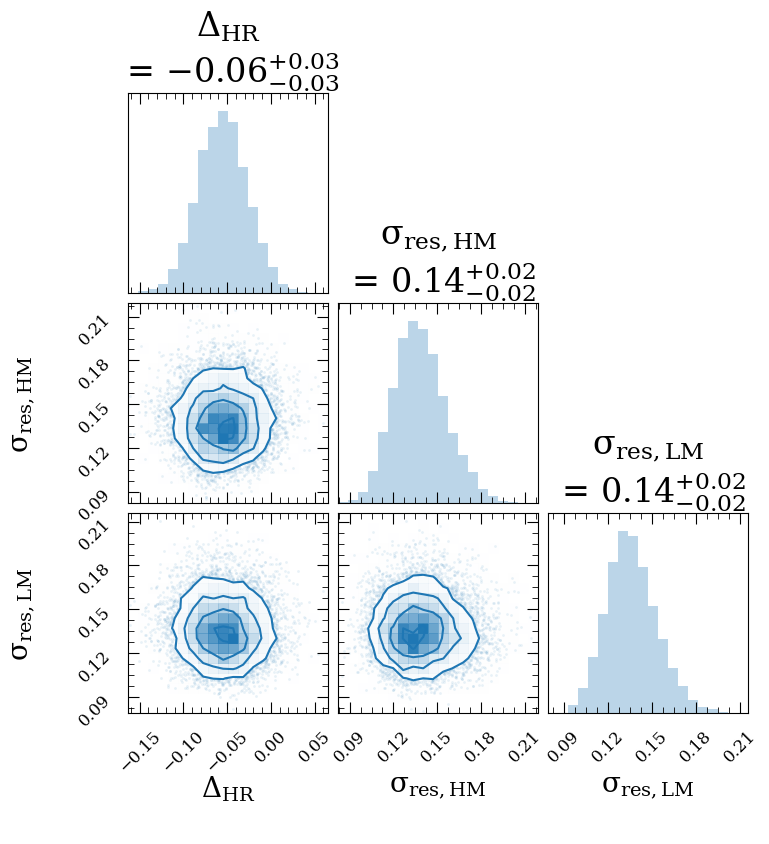

In [5]:
# Show the corner plot for the mass step parameters
fig = corner.corner(samples_dict, color='tab:blue', show_titles=True,
                    hist_kwargs={'histtype': 'stepfilled', 'color': 'tab:blue', 'alpha': 0.3},
                    labels=['$\\Delta_{HR}$\n', '$\\sigma_{res, HM}$\n', '$\\sigma_{res, LM}$\n'])

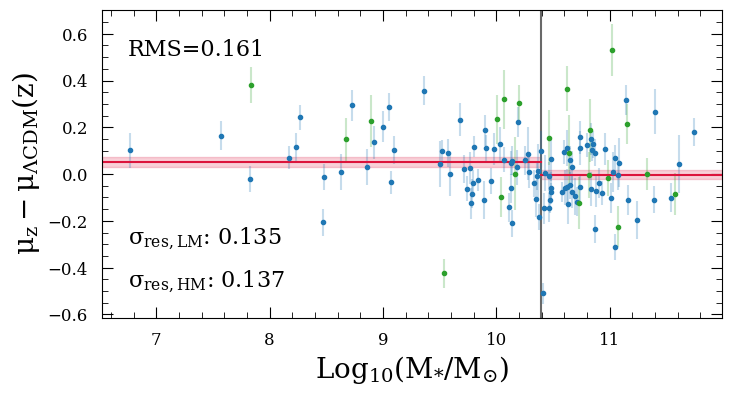

In [6]:
# Plot the Hubble residuals vs host galaxy mass with the fitted mean Hubble residuals in the LM/HM bins and the residual scatter shown
# As with the Hubble diagram, the kwarg dust_corrected will correct the distance modulus from a single band fit for dust.
fig, ax = utils.plot_mass_step(sample, fit_filters='z', dust_corrected=True, M_split=np.median(x),
                               samples=samples)